### Imports

In [1]:
import matplotlib.pyplot as plt
import scipy.signal as sg
from scipy import stats
import numpy as np
import pandas as pd
import subjects

### PSD Gamma power comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep
- PSD analysis didn't reveal any significant difference

In [ ]:
# sessions = subjects.nsd.brainstates_sess + subjects.sd.brainstates_sess
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy import stats

psd_df = []
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    if sess.tag=='SD':
        period = [post[0]+5*3600,post[1]] 
    else:
        period = [post[0],post[0]+5*3600]

    states= sess.brainstates.time_slice(period[0],period[1])['rem']
    channel = sess.ripple.metadata['channels'][3]
    trace = sess.eegfile.get_frames_within_epochs(states,82)
    b,a = sg.iirnotch(60,50,fs=1250)
    trace = sg.filtfilt(b,a,trace)
    trace = stats.zscore(trace)

    f,psd = sg.welch(trace,fs=1250,nperseg=1250,noverlap=250)

    df = pd.DataFrame(dict(freqs=f,psd=psd,grp=sess.tag))
    psd_df.append(df) 

psd_df = pd.concat(psd_df,ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

_,ax = plt.subplots()
sns.lineplot(data=psd_df,x='freqs',y='psd',hue='grp',ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')

### Hilbert Gamma comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep
- Here using hilbert amplitude across multiple electrodes depthwise across shank

In [ ]:
import numpy as np
import pandas as pd
import subjects

# sessions = subjects.nsd.brainstates_sess + subjects.sd.brainstates_sess
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy import stats
from neuropy.utils.signal_process import filter_sig,hilbertfast

hilbert_amp_df = []
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    if sess.tag=='SD':
        period = [post[0]+5*3600,post[1]] 
    else:
        period = [post[0],post[0]+5*3600]

    states= sess.brainstates.time_slice(period[0],period[1])['rem']
    good_chans = sess.probegroup.get_connected_channels(groupby='shank')[5]

    hilbert_amp = []
    for chan in good_chans: 
        trace = sess.eegfile.get_frames_within_epochs(states,chan)
        b,a = sg.iirnotch(60,50,fs=1250)
        trace = sg.filtfilt(b,a,trace)
        gamma_trace = filter_sig.bandpass(trace,fs=1250,lf=60,hf=90)
        hilbert_amp.append(stats.zscore(np.abs(hilbertfast(gamma_trace))).mean())

    hilbert_amp_df.append(pd.DataFrame(dict(gamma_amp=hilbert_amp,grp=sess.tag)))

hilbert_amp_df = pd.concat(hilbert_amp_df,ignore_index=True)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

_,ax = plt.subplots()

for grp in ['SD','NSD']:
    amp = hilbert_amp_df[hilbert_amp_df['grp']==grp].gamma_amp
    ax.plot(amp.values)


### CSD Gamma comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep
- CSD maps didn't reveal any significant difference, although implicit normalizations used for CSD analysis may attenuate the differences, will have to look more closely. 

In [ ]:
# sessions = subjects.nsd.brainstates_sess + subjects.sd.brainstates_sess
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [ ]:
import scipy.signal as sg
from scipy import stats
from neuropy.utils.signal_process import filter_sig, hilbertfast, Csd

csd_all = []
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    if sess.tag == "SD":
        period = [post[0] + 5 * 3600, post[1]]
    else:
        period = [post[0], post[0] + 5 * 3600]

    states = sess.brainstates.time_slice(period[0], period[1])["rem"]
    good_shank = sess.probegroup.get_connected_channels(groupby="shank")[5]
    trace = sess.eegfile.get_frames_within_epochs(states, chan)
    b, a = sg.iirnotch(60, 50, fs=1250)
    trace = sg.filtfilt(b, a, trace)
    gamma_lfp = filter_sig.bandpass(trace, fs=1250, lf=60, hf=90)

    epochs_frames = (states.as_array() * 1250).astype("int")
    frames = np.concatenate([np.arange(*e) for e in epochs_frames])
    shank_traces = sess.eegfile._raw_traces[np.ix_(good_shank.astype('int'),frames)]

    # --- Selecting channel with strongest theta for calculating theta peak-----
    peak = sg.find_peaks(gamma_lfp)[0]
    # Ignoring first and last second of data
    peak = peak[np.where((peak > 1250) & (peak < len(gamma_lfp) - 1250))[0]]

    window = 250
    nChans = 16
    # ---- averaging around theta cycle ---------------
    avg_theta = np.zeros((nChans, window))
    for ind in peak:
        avg_theta = avg_theta + shank_traces[:, ind - window // 2 : ind + window // 2]
    avg_theta = avg_theta / len(peak)

    ycoord = 240 - np.arange(16) * 15
    csd = Csd(lfp=avg_theta, coords=ycoord, chan_label=good_shank)
    csd.classic()

    csd_all.append(csd)


In [ ]:
%matplotlib widget
_,axs = plt.subplots(1,2)
axs = axs.reshape(-1)
for i,c in enumerate(csd_all): 
    c.plot(ax=axs[i],cmap='jet',vmin=-0.4,vmax=0.4,plotLFP=True)


### Gamma band coherence during sleep deprivation

In [187]:
sessions = subjects.sd.ratKday1
channels = [[13,39],[112,23]]

In [192]:
for sub, sess in enumerate(sessions):
    post = sess.paradigm["post"].flatten()
    signal = sess.eegfile.get_signal(
        channels[sub], post[0] - 3 * 3600, post[0] + 7 * 3600
    )
    lfp1, lfp2 = signal.traces

    coher_all = []
    corr = []
    for t in np.arange(10*60 - 2):
        start = t * 1250 * 60
        stop = start + 1250 * 60
        f, coher = sg.coherence(
            lfp1[start:stop],
            lfp2[start:stop],
            fs=1250,
            nperseg=2 * 1250,
            noverlap=1 * 1250,
        )
        coher_all.append(coher)
        corr.append(np.corrcoef(lfp1[start:stop],lfp2[start:stop])[0,1])

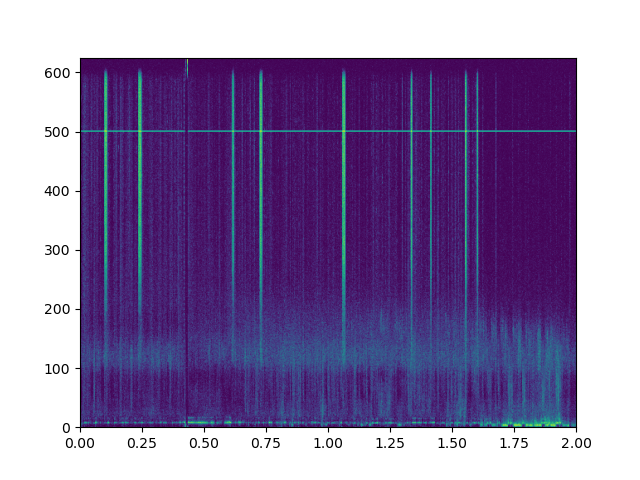

In [193]:
_,ax = plt.subplots()

ax.imshow(np.asarray(coher_all).T,aspect='auto',origin='lower',extent=[0,2,0,625])
# ax.set_xscale("log")
# ax.set_yscale("log")

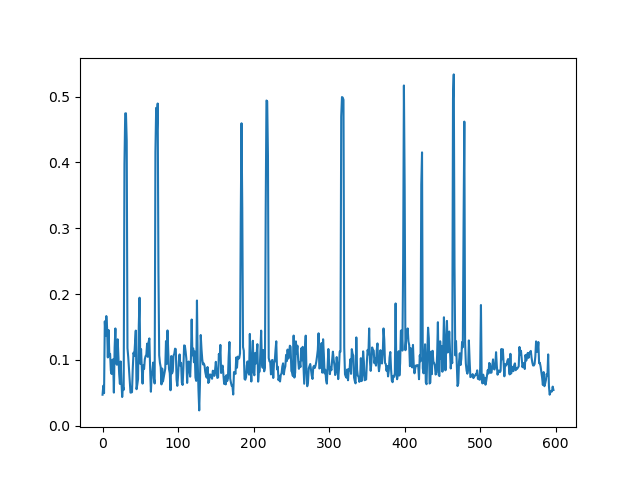

In [195]:
_,ax = plt.subplots()


ax.plot(np.asarray(coher_all).T[:,:].mean(axis=0))
# ax.plot(corr)